##  **作业说明：**

**✓代码跑通**

请大家根据课上所学内容，在 U-Net类中补全代码，构造U-Net 网络，保证程序跑通。在U-Net构造成功的基础上，可尝试构造其他网络。

**✓调优**

思考并动手进行调优，以在验证集上的准确率为评价指标，验证集上准确率越高，得分越高！

## **任务描述：**
如何根据据图像的视觉内容实现图像的语义分割。图像分割是计算机视觉中一个重要的任务，广泛应用于自动驾驶、三维重建等领域之中。

实践内容：利用飞桨动态图搭建一个U-Net网络，对包含的图片进行语义分割。

**特别提示：本实践所用数据集均来自互联网，请勿用于商务用途。**

## （一）图像分割概述

图像分割是计算机视觉中一个重要的任务，广泛应用于自动驾驶、三维重建等领域之中。从分割对象的角度来看，图像分割包括语义分割，实例分割以及全景分割等。语义分割的目标是为图像中的每个像素分类，而对于同一物体的不同实例，不需要单独分割。实例分割是目标检测和语义分割的结合，需要分割出同一物体的不同个体。全景分割是语义分割和实例分割的结合，全景分割要求对图像中的所有物体包括背景都要进行检测和分割。通常意义上的图像分割指的是语义分割。

本项目旨在简要介绍如何通过飞桨开源框架的2.0全新版本实现图像的语义分割。这里我们选择了一个在医学图像分割领域最为熟知的U-Net网络结构，以其U型结构命名，网络结构主要分为三部分：编码器部分，解码器部分以及跳跃连接。编码器部分主要通过卷积和下采样的堆叠来降低图像尺寸，提取特征。解码部分通过卷积和上采样的堆叠恢复图像分辨率。中间通过跳跃连接的方式，将编码阶段获得的feature map同解码阶段获得的feature map结合在一起，结合深层次和浅层次的特征，细化图像，根据得到的feature map进行预测分割。

## （二）环境设置

导入一些可能用到的常用的模块，设置GPU的运行方式，确认使用的飞桨版本。

In [1]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PilImage

import paddle
from paddle.nn import functional as F

paddle.set_device('gpu')
paddle.__version__

'2.5.2'

## （三）数据集

### 3.1 数据集下载

本项目使用Oxford-IIIT Pet数据集，是包括37个类别的宠物数据集，每个类别大约有200张图像。

官网：https://www.robots.ox.ac.uk/~vgg/data/pets 。

数据集统计如下：

![alt 数据集统计信息](https://www.robots.ox.ac.uk/~vgg/data/pets/breed_count.jpg)

数据集包含两个压缩文件：

1. 原图：https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
2. 分割图像：https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

In [4]:
# 解压缩数据集
!tar -xf data/images.tar.gz
!tar -xf data/annotations.tar.gz

活动代码页: 936
活动代码页: 936


### 3.2 数据集概览

首先我们先看看下载到磁盘上的文件结构是什么样，来了解一下我们的数据集。

1. 首先看一下images.tar.gz这个压缩包，该文件解压后得到一个images目录，这个目录比较简单，里面直接放的是用类名和序号命名好的图片文件，每个图片是对应的宠物照片。

```bash
.
├── samoyed_7.jpg
├── ......
└── samoyed_81.jpg
```

2. 然后我们再看下annotations.tar.gz，文件解压后的目录里面包含以下内容，目录中的README文件将每个目录和文件做了比较详细的介绍，我们可以通过README来查看每个目录文件的说明。

```bash
.
├── README
├── list.txt
├── test.txt
├── trainval.txt
├── trimaps
│    ├── Abyssinian_1.png
│    ├── Abyssinian_10.png
│    ├── ......
│    └── yorkshire_terrier_99.png
└── xmls
      ├── Abyssinian_1.xml
      ├── Abyssinian_10.xml
      ├── ......
      └── yorkshire_terrier_190.xml
```

本次我们主要使用到images和annotations/trimaps两个目录，即原图和三元图像文件，前者作为训练的输入数据，后者是对应的标签数据。

我们来看看这个数据集给我们提供了多少个训练样本。

In [5]:
IMAGE_SIZE = (160, 160)
train_images_path = "images/"
label_images_path = "annotations/trimaps/"
image_count = len([os.path.join(train_images_path, image_name) for image_name in os.listdir(train_images_path) if image_name.endswith('.jpg')])
print("图像样本的总数量是:", image_count)

# 对数据集进行处理，划分训练集、测试集
def _sort_images(image_dir, image_type):
    """
    对文件夹内的图像进行按照文件名排序
    """
    files = []

    for image_name in os.listdir(image_dir):
        if image_name.endswith('.{}'.format(image_type)) \
                and not image_name.startswith('.'):
            files.append(os.path.join(image_dir, image_name))

    return sorted(files)

def write_file(mode, images, labels):
    with open('./{}.txt'.format(mode), 'w') as f:
        for i in range(len(images)):
            f.write('{}\t{}\n'.format(images[i], labels[i]))
    
"""
由于所有文件都是散落在文件夹中，在训练时我们需要使用的是数据集和标签对应的数据关系，
所以我们第一步是对原始的数据集进行整理，得到数据集和标签两个数组，分别一一对应。
这样可以在使用的时候能够很方便的找到原始数据和标签的对应关系，否则对于原有的文件夹图片数据无法直接应用。
在这里是用了一个非常简单的方法，按照文件名称进行排序。
因为刚好数据和标签的文件名是按照这个逻辑制作的，名字都一样，只有扩展名不一样。
"""
images = _sort_images(train_images_path, 'jpg')
labels = _sort_images(label_images_path, 'png')
eval_num = int(image_count * 0.15)

write_file('train', images[:-eval_num], labels[:-eval_num])
write_file('test', images[-eval_num:], labels[-eval_num:])
write_file('predict', images[-eval_num:], labels[-eval_num:])

图像样本的总数量是: 7390


### 3.3 PetDataSet数据集抽样展示

划分好数据集之后，我们来查验一下数据集是否符合预期，我们通过划分的配置文件读取图片路径后再加载图片数据来用matplotlib进行展示，这里要注意的是对于分割的标签文件因为是1通道的灰度图片，需要在使用imshow接口时注意下传参cmap='gray'。

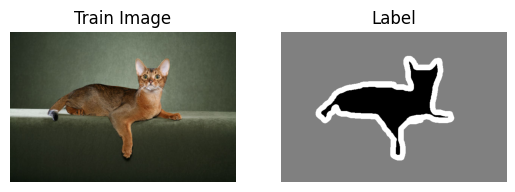

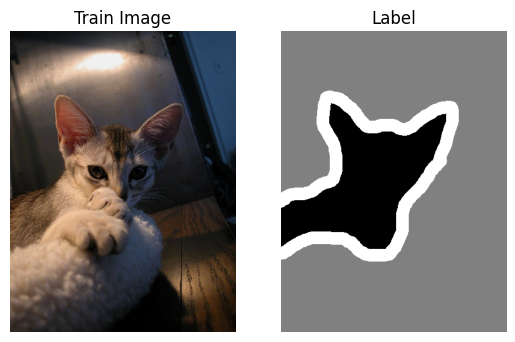

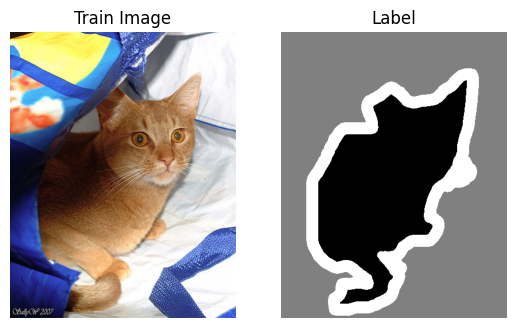

In [6]:
with open('./train.txt', 'r') as f:
    i = 0

    for line in f.readlines():
        image_path, label_path = line.strip().split('\t')
        image = np.array(PilImage.open(image_path))
        label = np.array(PilImage.open(label_path))
    
        if i > 2:
            break
        # 进行图片的展示
        plt.figure()

        plt.subplot(1,2,1), 
        plt.title('Train Image')
        plt.imshow(image.astype('uint8'))
        plt.axis('off')

        plt.subplot(1,2,2), 
        plt.title('Label')
        plt.imshow(label.astype('uint8'), cmap='gray')
        plt.axis('off')

        plt.show()
        i = i + 1

### 3.4 数据集类定义

飞桨（PaddlePaddle）数据集加载方案是统一使用Dataset（数据集定义） + DataLoader（多进程数据集加载）。

首先我们先进行数据集的定义，数据集定义主要是实现一个新的Dataset类，继承父类paddle.io.Dataset，并实现父类中以下两个抽象方法，`__getitem__`和`__len__`：

```python
class MyDataset(Dataset):
    def __init__(self):
        ...
        
    # 每次迭代时返回数据和对应的标签
    def __getitem__(self, idx):
        return x, y

    # 返回整个数据集的总数
    def __len__(self):
        return count(samples)
```

在数据集内部可以结合图像数据预处理相关API进行图像的预处理（改变大小、反转、调整格式等）。

由于加载进来的图像不一定都符合自己的需求，举个例子，已下载的这些图片里面就会有RGBA格式的图片，这个时候图片就不符合我们所需3通道的需求，我们需要进行图片的格式转换，那么这里我们直接实现了一个通用的图片读取接口，确保读取出来的图片都是满足我们的需求。

另外图片加载出来的默认shape是HWC，这个时候要看看是否满足后面训练的需要，如果Layer的默认格式和这个不是符合的情况下，需要看下Layer有没有参数可以进行格式调整。不过如果layer较多的话，还是直接调整原数据Shape比较好，否则每个layer都要做参数设置，如果有遗漏就会导致训练出错，那么在本案例中是直接对数据源的shape做了统一调整，从HWC转换成了CHW，因为飞桨的卷积等API的默认输入格式为CHW，这样处理方便后续模型训练。

In [7]:
import random

from paddle.io import Dataset
from paddle.vision.transforms import transforms as T


class PetDataset(Dataset):
    """
    数据集定义
    """
    def __init__(self, mode='train'):
        """
        构造函数
        """
        self.image_size = IMAGE_SIZE
        self.mode = mode.lower()
        
        assert self.mode in ['train', 'test', 'predict'], \
            "mode should be 'train' or 'test' or 'predict', but got {}".format(self.mode)
        
        self.train_images = []
        self.label_images = []

        with open('./{}.txt'.format(self.mode), 'r') as f:
            for line in f.readlines():
                image, label = line.strip().split('\t')
                self.train_images.append(image)
                self.label_images.append(label)
        
    def _load_img(self, path, color_mode='rgb', transforms=[]):
        """
        统一的图像处理接口封装，用于规整图像大小和通道
        """
        with open(path, 'rb') as f:
            img = PilImage.open(io.BytesIO(f.read()))
            if color_mode == 'grayscale':
                # if image is not already an 8-bit, 16-bit or 32-bit grayscale image
                # convert it to an 8-bit grayscale image.
                if img.mode not in ('L', 'I;16', 'I'):
                    img = img.convert('L')
            elif color_mode == 'rgba':
                if img.mode != 'RGBA':
                    img = img.convert('RGBA')
            elif color_mode == 'rgb':
                if img.mode != 'RGB':
                    img = img.convert('RGB')
            else:
                raise ValueError('color_mode must be "grayscale", "rgb", or "rgba"')
            
            return T.Compose([
                T.Resize(self.image_size)
            ] + transforms)(img)

    def __getitem__(self, idx):
        """
        返回 image, label
        """
        train_image = self._load_img(self.train_images[idx], 
                                     transforms=[
                                         T.Transpose(), 
                                         T.Normalize(mean=127.5, std=127.5)
                                     ]) # 加载原始图像
        label_image = self._load_img(self.label_images[idx], 
                                     color_mode='grayscale',
                                     transforms=[T.Grayscale()]) # 加载Label图像
    
        # 返回image, label
        train_image = np.array(train_image, dtype='float32')
        label_image = np.array(label_image, dtype='int64')
        return train_image, label_image
        
    def __len__(self):
        """
        返回数据集总数
        """
        return len(self.train_images)

## （四）模型结构

U-Net是一个U型网络结构，可以看做两个大的阶段，图像先经过Encoder编码器进行下采样得到高级语义特征图，再经过Decoder解码器上采样将特征图恢复到原图片的分辨率。

网络结构如下图所示：

![alt U_Net结构](https://img-blog.csdnimg.cn/20200301123339296.jpg?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L2xpYW5naGU3Nw==,size_16,color_FFFFFF,t_70)

### 4.1 下采样相关

DoubleConv类实现两次Conv-BN-ReLU的堆叠，Down类实现下采样，具体为一次max pooling最大池化加上两次Conv-BN-ReLU的堆叠。

In [8]:
class DoubleConv(paddle.nn.Layer):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()

        self.double_conv = paddle.nn.Sequential(
            paddle.nn.Conv2D(in_channels, out_channels, kernel_size=3, padding=1),
            paddle.nn.BatchNorm2D(out_channels),
            paddle.nn.ReLU(),
            paddle.nn.Conv2D(out_channels, out_channels, kernel_size=3, padding=1),
            paddle.nn.BatchNorm2D(out_channels),
            paddle.nn.ReLU()
        )
 
    def forward(self, x):
        return self.double_conv(x)

In [9]:

class Down(paddle.nn.Layer):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = paddle.nn.Sequential(
            paddle.nn.MaxPool2D(kernel_size=2, stride=2, padding=0),
            DoubleConv(in_channels, out_channels)
        )
 
    def forward(self, x):
        return self.maxpool_conv(x)

### 4.2 上采样相关

在通道数达到最大得到高级语义特征图后，网络结构会开始进行解码操作，进行上采样，通道数逐渐减小，对应图片尺寸逐步增加，直至恢复到原图像大小。Up类主要实现上采样以及跳跃连接。上采样可以通过双线性插值和反卷积两种方式实现。

In [10]:
class Up(paddle.nn.Layer):
    """Upscaling then double conv"""
 
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
 
        if bilinear:
            self.up = paddle.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = paddle.nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
 
        self.conv = DoubleConv(in_channels, out_channels)
 
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # print(x2.shape, x1.shape)
        # print(x2.shape[2] - x1.shape[2])
        diffY = paddle.to_tensor([x2.shape[2] - x1.shape[2]])
        diffX = paddle.to_tensor([x2.shape[3] - x1.shape[3]])
 
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
 
        x = paddle.concat([x2, x1], axis=1)
        return self.conv(x)

### 4.3 模型整体结构

如下为U_Net的整体网络结构，总共经历四次下采样以及四次上采样。

**请在此补充代码（上采样、下采样相关代码已经在给出直接调用即可）**

In [11]:
class U_Net(paddle.nn.Layer):
    def __init__(self, num_classes, bilinear=True):
        super(U_Net, self).__init__()
        
        self.num_classes = num_classes
        self.bilinear = bilinear
        self.inc = DoubleConv(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)

        self.output_conv = paddle.nn.Conv2D(64, num_classes, kernel_size=1)
    
    def forward(self, inputs):
        x1 = self.inc(inputs)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        y = self.output_conv(x)
        
        return y

### 4.4 模型可视化

调用飞桨提供的summary接口对组建好的模型进行可视化，方便进行模型结构和参数信息的查看和确认。

In [12]:
num_classes = 4
network = U_Net(num_classes)
model = paddle.Model(network)
model.summary((-1, 3,) + IMAGE_SIZE)

-------------------------------------------------------------------------------------------
 Layer (type)               Input Shape                  Output Shape         Param #    
   Conv2D-1              [[1, 3, 160, 160]]           [1, 64, 160, 160]        1,792     
 BatchNorm2D-1          [[1, 64, 160, 160]]           [1, 64, 160, 160]         256      
    ReLU-1              [[1, 64, 160, 160]]           [1, 64, 160, 160]          0       
   Conv2D-2             [[1, 64, 160, 160]]           [1, 64, 160, 160]       36,928     
 BatchNorm2D-2          [[1, 64, 160, 160]]           [1, 64, 160, 160]         256      
    ReLU-2              [[1, 64, 160, 160]]           [1, 64, 160, 160]          0       
 DoubleConv-1            [[1, 3, 160, 160]]           [1, 64, 160, 160]          0       
  MaxPool2D-1           [[1, 64, 160, 160]]            [1, 64, 80, 80]           0       
   Conv2D-3              [[1, 64, 80, 80]]             [1, 128, 80, 80]       73,856     
 BatchNo

{'total_params': 13403460, 'trainable_params': 13395524}

## 5.模型训练~~~~

### 5.1 启动模型训练

使用模型代码进行Model实例生成，使用prepare接口定义优化器、损失函数和评价指标等信息，用于后续训练使用。在所有初步配置完成后，调用fit接口开启训练执行过程，调用fit时只需要将前面定义好的训练数据集、测试数据集、训练轮次（Epoch）和批次大小（batch_size）配置好即可。

In [13]:
train_dataset = PetDataset(mode='train') # 训练数据集
val_dataset = PetDataset(mode='test') # 验证数据集

optim = paddle.optimizer.RMSProp(learning_rate=0.001, rho=0.9, 
                                 momentum=0.0, epsilon=1e-07, 
                                 centered=False,parameters=model.parameters())

model.prepare(optim, paddle.nn.CrossEntropyLoss(axis=1))

model.fit(train_dataset, val_dataset, epochs=1, batch_size=32, verbose=2)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/1


c:\Users\12631\AppData\Local\Programs\Python\Python39\lib\site-packages\paddle\nn\layer\norm.py:777: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


step  10/197 - loss: 0.9484 - 11s/step
step  20/197 - loss: 0.8320 - 11s/step
step  30/197 - loss: 0.7771 - 10s/step
step  40/197 - loss: 0.7011 - 10s/step
step  50/197 - loss: 0.7458 - 10s/step
step  60/197 - loss: 0.6404 - 10s/step
step  70/197 - loss: 0.5712 - 10s/step
step  80/197 - loss: 0.5859 - 10s/step
step  90/197 - loss: 0.6139 - 10s/step
step 100/197 - loss: 0.5536 - 10s/step
step 110/197 - loss: 0.6765 - 10s/step


## （六）模型评估

In [12]:
model.evaluate(val_dataset, batch_size=64, verbose=1)

Eval begin...
The loss value printed in the log is the current batch, and the metric is the average value of previous step.
step 18/18 [==============================] - loss: 0.4659 - 501ms/step         
Eval samples: 1108


{'loss': [0.4659145]}

## （七）模型预测

### 7.1 预测数据集准备和预测

继续使用PetDataset来实例化待预测使用的数据集。这里我们为了方便没有在另外准备预测数据，复用了评估数据。

我们可以直接使用model.predict接口来对数据集进行预测操作，只需要将预测数据集传递到接口内即可。

In [13]:
predict_dataset = PetDataset(mode='predict')
predict_results = model.predict(predict_dataset)

Predict begin...
step 1108/1108 [==============================] - 19ms/step        
Predict samples: 1108


In [14]:
import numpy as np
def diceCoeff(preds, gts, eps=1e-5):
    """ 
    preds列表，其中的每一个统一到单通道
    
    计算公式：
        dice = (2 * (pred ∩ gt)) / (pred ∪ gt)
    """
    pred = np.concatenate([np.expand_dims(pred,0) for pred in preds], axis=0)
    gt = np.concatenate([np.expand_dims(gt,0) for gt in gts], axis=0)

    eval_results = 0
    c = data.shape[2]
    N = pred.shape[0]

    pred_flat = pred.reshape(N, -1)
    gt_flat = gt.reshape(N, -1)
    
    for i in range(1, c):
        unionset = np.sum(pred_flat==i, 1) + np.sum(gt_flat==i, 1)
        pred_tmp, gt_tmp = pred_flat, gt_flat
        pred_tmp[pred_tmp==i]=1
        pred_tmp[pred_tmp!=i]=0
        gt_tmp[gt_tmp==i]=1
        gt_tmp[gt_tmp!=i]=0
        intersection = np.sum(pred_tmp * gt_tmp, 1)
        eval_results +=  (2 * intersection + eps) / (unionset + eps)

    return eval_results/(c-1)/N

### 7.2 预测结果可视化

从我们的预测数据集中抽3个动物来看看预测的效果，展示一下原图、标签图和预测结果。

[1 2 3]
指标结果： [0.94573284]
[1 2 3]
指标结果： [0.9658543]
[1 2 3]
指标结果： [0.94139353]


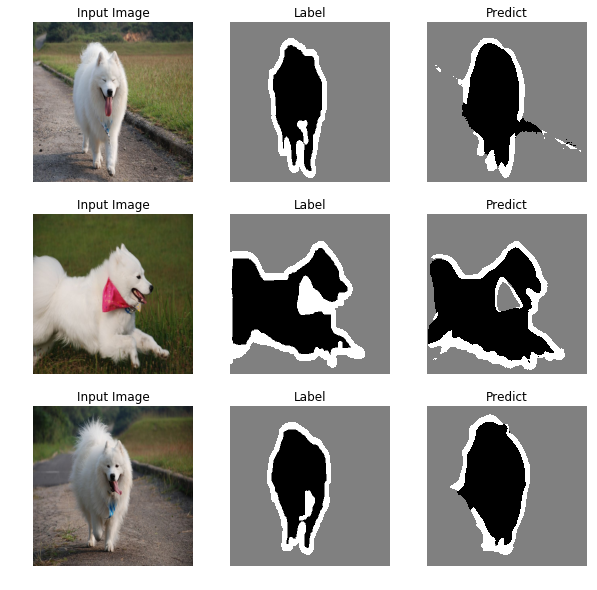

In [15]:
plt.figure(figsize=(10, 10))

i = 0
mask_idx = 0
pred_list = []
gt_list = []
with open('./predict.txt', 'r') as f:
    for line in f.readlines():
        image_path, label_path = line.strip().split('\t')
        resize_t = T.Compose([
            T.Resize(IMAGE_SIZE)
        ])
        image = resize_t(PilImage.open(image_path))
        label = resize_t(PilImage.open(label_path))

        image = np.array(image).astype('uint8')
        label = np.array(label).astype('uint8')

        if i > 8: 
            break
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title('Input Image')
        plt.axis("off")

        plt.subplot(3, 3, i + 2)
        plt.imshow(label, cmap='gray')
        plt.title('Label')
        plt.axis("off")
        
        # 模型只有一个输出，所以我们通过predict_results[0]来取出1000个预测的结果
        # 映射原始图片的index来取出预测结果，提取mask进行展示
        data = predict_results[0][mask_idx][0].transpose((1, 2, 0))
        mask = np.argmax(data, axis=-1)
        print(np.unique(mask))
        pred_list.append(mask)
        gt_list.append(label)

        print('指标结果：', diceCoeff(pred_list, gt_list))

        plt.subplot(3, 3, i + 3)
        plt.imshow(mask.astype('uint8'), cmap='gray')
        plt.title('Predict')
        plt.axis("off")
        i += 3
        mask_idx += 1
        pred_list=[]
        gt_list=[]

plt.show()

输出结果指标：

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[0.9197952]


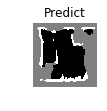

In [16]:
i = 0
mask_idx = 0
pred_list = []
gt_list = []
dice_sum=0
with open('./predict.txt', 'r') as f:
    for line in f.readlines():
        image_path, label_path = line.strip().split('\t')
        resize_t = T.Compose([
            T.Resize(IMAGE_SIZE)
        ])
        image = resize_t(PilImage.open(image_path))
        label = resize_t(PilImage.open(label_path))

        image = np.array(image).astype('uint8')
        label = np.array(label).astype('uint8')
        # 模型只有一个输出，所以我们通过predict_results[0]来取出1000个预测的结果
        # 映射原始图片的index来取出预测结果，提取mask进行展示
        data = predict_results[0][mask_idx][0].transpose((1, 2, 0))
        mask = np.argmax(data, axis=-1)
        pred_list.append(mask)
        gt_list.append(label)

        dice_sum=dice_sum+diceCoeff(pred_list, gt_list)

        plt.subplot(3, 3, i + 3)
        plt.imshow(mask.astype('uint8'), cmap='gray')
        plt.title('Predict')
        plt.axis("off")
        mask_idx += 1
        pred_list=[]
        gt_list=[]
print(dice_sum/mask_idx)
